In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import xgboost as xgb
import re
import nltk
import pickle
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
stop=set(stopwords.words('english'));
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.models import Sequential
from keras.callbacks import EarlyStopping
from nltk.stem import *
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)


## !pip install transformers
## To run this notebook, two files need to be uploaded:
### 'LSTM.pkl' and 'train.csv'


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
train = pd.read_csv('train.csv')
df = train
df['comment_text'] = df['comment_text'].astype(str)

In [ ]:
df.head(2)

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,acd47a6c06c4d1f8,Fuck Wikipedia!!! \n\nPeace (except to Wikipedia),1,1,1,0,0,0
1,1,0dd47ea93d47e518,Re-adding anti-barnstar\n Anti-Barnstar,0,0,0,0,0,0


## EDA

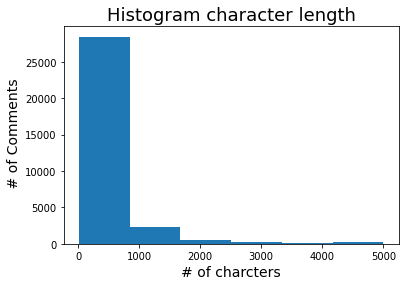


COMMENT:   Most comments have under 1000


In [ ]:
plt.hist(df['comment_text'].str.len(), bins=6)#.hist()
plt.title('Histogram character length', fontsize =18)
plt.ylabel(' # of Comments',fontsize =14)
plt.xlabel('# of charcters',fontsize =14);
plt.show()
print('')
print('COMMENT:   Most comments have under 1000')



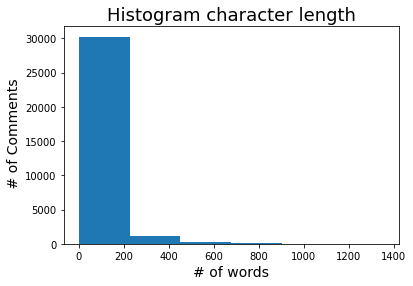


COMMENT:   Most comments have under 230


In [ ]:

a = df['comment_text'].str.split().map(lambda x: len(x))
plt.hist(a, bins=6)#.hist()
plt.title('Histogram character length', fontsize =18)
plt.ylabel(' # of Comments',fontsize =14)
plt.xlabel('# of words',fontsize =14);
plt.show()
print('')
print('COMMENT:   Most comments have under 230')


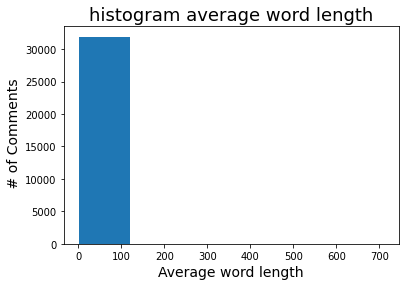


COMMENT:  comments have an average word count under 250 words


In [ ]:
a = df['comment_text'].str.split().apply(lambda x : [len(i) for i in x]).map(lambda x: np.mean(x))
plt.hist(a, bins=6)#.hist()
plt.title('histogram average word length', fontsize =18)
plt.ylabel(' # of Comments',fontsize =14)
plt.xlabel('Average word length',fontsize =14);
plt.show()
print('')
print('COMMENT:  comments have an average word count under 130 words')




### STOP WORDS

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
corpus=[]
new= df['comment_text'].str.split()
new=new.values.tolist()
corpus=[word for i in new for word in i]

from collections import defaultdict
dic=defaultdict(int)
for word in corpus:
    if word in stop:
        dic[word]+=1

<BarContainer object of 10 artists>

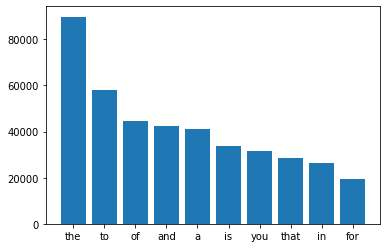

In [ ]:
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)

### most frequent words excluding stop words

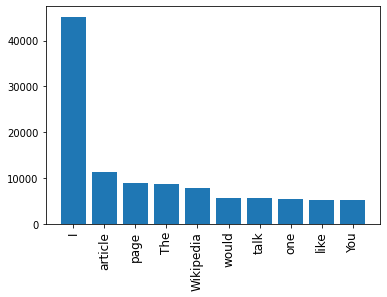

In [ ]:
from nltk.tokenize import RegexpTokenizer
l = []
tokenizer = RegexpTokenizer(r'\w+')
for i in df['comment_text']:
    l.extend(tokenizer.tokenize(i))
 


dic=defaultdict(int)
for word in l:
    if word not in stop:
        dic[word]+=1
        
top=sorted(dic.items(), key=lambda x:x[1],reverse=True)[:10] 
x,y=zip(*top)
plt.bar(x,y)
plt.xticks(x, [str(i) for i in x], rotation=90)
plt.tick_params(axis='x', which='major', labelsize=12)

### Ngrams: Contiguous sequences of words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns

In [ ]:
def get_top_ngram(corpus, n=None):
    vec = CountVectorizer(ngram_range=(n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx])
                  for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:10]

<AxesSubplot:>

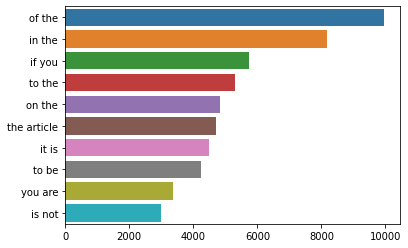

In [ ]:
top_n_bigrams=get_top_ngram(df['comment_text'],2)[:10] 
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)


<AxesSubplot:>

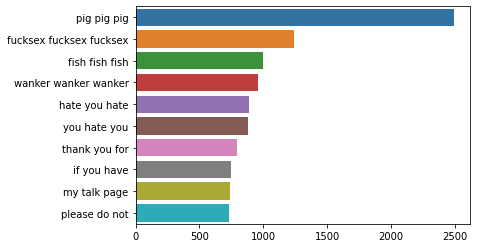

In [ ]:
top_n_bigrams=get_top_ngram(df['comment_text'],3)[:10] 
x,y=map(list,zip(*top_n_bigrams))
sns.barplot(x=y,y=x)

### Visualising the number of comments per category


In [ ]:
df_viz = df

In [ ]:
x=df_viz.iloc[:,3:].sum()
#marking comments without any tags as "clean"
rowsums=df_viz.iloc[:,2:].sum(axis=1)
df_viz['clean']=(rowsums==0)
df_viz['clean'].sum()

<ipython-input-4-acbf69ce9c48>:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  rowsums=df_viz.iloc[:,2:].sum(axis=1)


28728

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


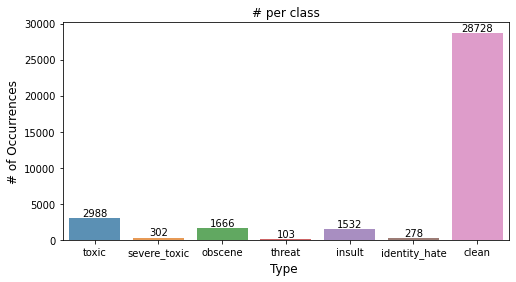

In [ ]:
x=df_viz.iloc[:,3:].sum()

#plot
plt.figure(figsize=(8,4));
ax= sns.barplot(x.index, x.values, alpha=0.8);
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show();

### Creating word clouds to see the most common words

In [ ]:
from wordcloud import WordCloud ,STOPWORDS
from PIL import Image
import matplotlib_venn as venn
stopword=set(STOPWORDS)

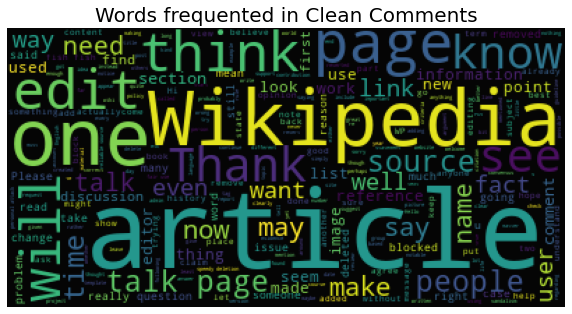

In [ ]:
#wordcloud for clean comments
subset=train[train.clean==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(10,10))
plt.axis("off")
plt.title("Words frequented in Clean Comments", fontsize=20)
plt.imshow(wc.recolor(colormap= 'viridis' , random_state=17), alpha=0.98)
plt.show()

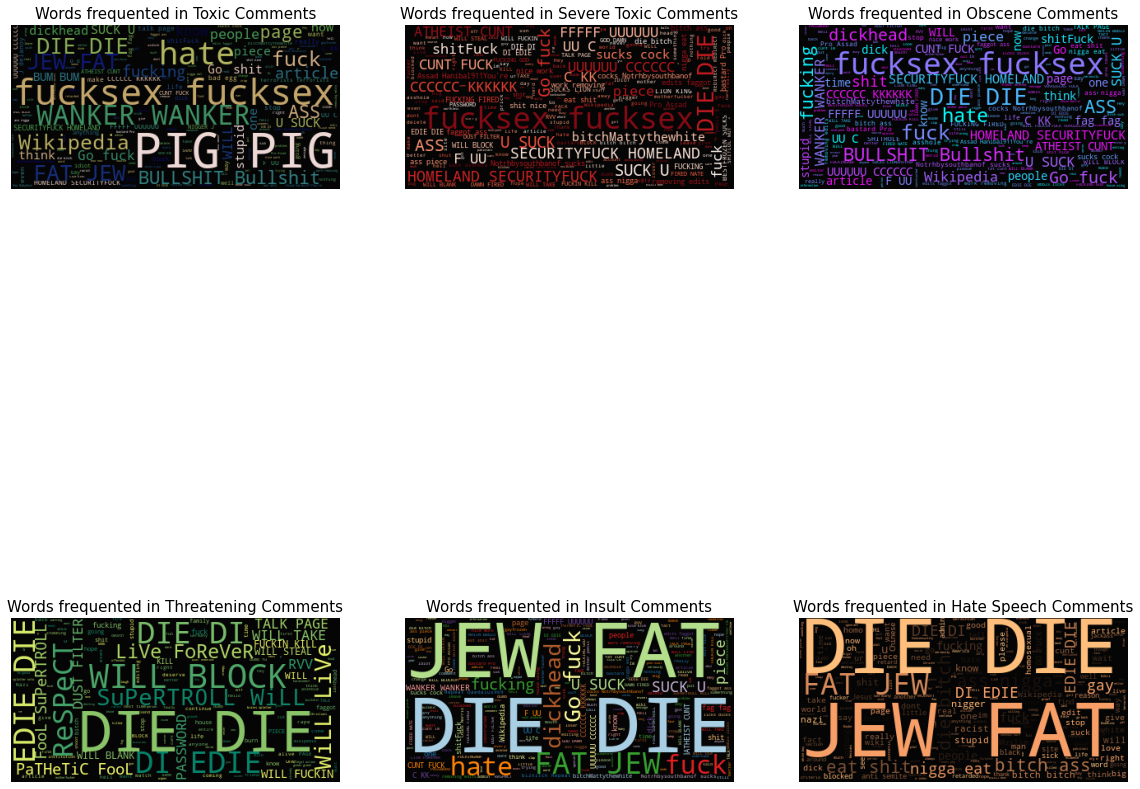

In [ ]:
#Toxic comments
subset=train[train.toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=4000,stopwords=stopword)
wc.generate(" ".join(text))
plt.figure(figsize=(20,20))

# Plot 1
plt.subplot(231)
plt.axis("off")
plt.title("Words frequented in Toxic Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98)

#Severely toxic comments
plt.subplot(232)
subset=train[train.severe_toxic==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Severe Toxic Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'Reds' , random_state=244), alpha=0.98)

#Obscene comments
plt.subplot(233)
subset=train[train.obscene==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Obscene Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'cool' , random_state=2534), alpha=0.98)

#Threat comments
plt.subplot(234)
subset=train[train.threat==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Threatening Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'summer' , random_state=2534), alpha=0.98)

#Insult comments
plt.subplot(235)
subset=train[train.insult==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Insult Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'Paired_r' , random_state=244), alpha=0.98)

#Hate Speech comments
plt.subplot(236)
subset=train[train.identity_hate==1]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=2000,stopwords=stopword)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Words frequented in Hate Speech Comments", fontsize=15)
plt.imshow(wc.recolor(colormap= 'copper' , random_state=244), alpha=0.98)

plt.show()


## Preprocessing

In [ ]:
import pandas as pd
import re
from nltk.stem import *
from nltk.corpus import stopwords
import re
df = pd.read_csv('train.csv')


In [ ]:
df['comment_text'] = df['comment_text'].astype(str)

In [ ]:
## Function to preprocess text:
### Eliminating stop words, 
def process_text(raw_text):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]
    
    return( " ".join( stemmed ))  
df['comment_text'] = df['comment_text'].apply(lambda x: process_text(x))


In [ ]:
text = df['comment_text'].values

## Modeling
### Sample Dataset chosen does not contain severe_toxic, threat, or identity_hate

In [ ]:
def evaluation_report(y_test, predictions):
  # Evaluate the accuracy of the model
  print('Accuracy:', accuracy_score(y_test, predictions))
  print('Values:', list(range(1,6)))
  print('Labels:', list(y_test.columns))
  print(' ')
  print('                       Classification Report')
  print(' ')

  print(classification_report(y_test, predictions))
  print(' ')

### Model 0: TF-IDF Decision Tree

In [ ]:

# Select a label to classify
target_label = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df['comment_text'], df[target_label], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer and fit it on the training set
tfidf = TfidfVectorizer(strip_accents='unicode', stop_words='english')
tfidf.fit(X_train)

# Transform the training and testing sets into TF-IDF vectors
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

# training a DescisionTreeClassifier
from sklearn.tree import DecisionTreeClassifier
dtree_model = DecisionTreeClassifier(max_depth = 2).fit(X_train_tfidf, y_train)
dtree_predictions = dtree_model.predict(X_test_tfidf)
  


In [ ]:
evaluation_report(y_test, dtree_predictions)
print('Decision Tree Model was not able to identify severe_toxic, threat, or identity_hate comments')

Accuracy: 0.911170296099013
Values: [1, 2, 3, 4, 5]
Labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
 
                       Classification Report
 
              precision    recall  f1-score   support

           0       0.91      0.29      0.44       584
           1       0.00      0.00      0.00        59
           2       0.88      0.49      0.63       332
           3       0.00      0.00      0.00        14
           4       0.68      0.41      0.52       304
           5       0.00      0.00      0.00        63

   micro avg       0.83      0.34      0.48      1356
   macro avg       0.41      0.20      0.26      1356
weighted avg       0.76      0.34      0.46      1356
 samples avg       0.02      0.02      0.02      1356

 


### Model 1: TF-IDF Random Forest

In [ ]:
# training a DescisionTreeClassifier
RFc = RandomForestClassifier().fit(X_train_tfidf, y_train)
RFc_predictions = RFc.predict(X_test_tfidf)

In [ ]:
evaluation_report(y_test, RFc_predictions)
print('Random forest Model was able to identify all labels sucessfully unlike Decision Trees.')
print('Random Forest had high precision across all classes, but low recall on severe_toxic, threat comments, and identity_hate.')

Accuracy: 0.928090239699201
Values: [1, 2, 3, 4, 5]
Labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
 
                       Classification Report
 
              precision    recall  f1-score   support

           0       0.88      0.67      0.76       584
           1       0.82      0.15      0.26        59
           2       0.91      0.76      0.82       332
           3       1.00      0.29      0.44        14
           4       0.81      0.57      0.67       304
           5       0.60      0.05      0.09        63

   micro avg       0.87      0.61      0.72      1356
   macro avg       0.84      0.41      0.51      1356
weighted avg       0.85      0.61      0.70      1356
 samples avg       0.06      0.05      0.05      1356

 
Random forest Model was able to identify all labels sucessfully unlike Decision Trees.
Random Forest had high precision across all classes, but low recall on severe_toxic, threat comments, and identity_hate.


### Model 2: TF-IDF KNeighbors Classifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train_tfidf, y_train)
neigh_pred = neigh.predict(X_test_tfidf)

evaluation_report(y_test, neigh_pred)
#print('Random forest Model was able to identify all labels sucessfully unlike Decision Trees.')
#print('Random Forest had high precision across all classes, but low recall on severe_toxic, threat comments, and identity_hate.')


Accuracy: 0.9063136456211812
Values: [1, 2, 3, 4, 5]
Labels: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
 
                       Classification Report
 
              precision    recall  f1-score   support

           0       0.88      0.17      0.29       584
           1       0.57      0.22      0.32        59
           2       0.85      0.20      0.32       332
           3       0.50      0.07      0.12        14
           4       0.79      0.15      0.25       304
           5       0.60      0.10      0.16        63

   micro avg       0.81      0.17      0.28      1356
   macro avg       0.70      0.15      0.24      1356
weighted avg       0.82      0.17      0.28      1356
 samples avg       0.01      0.01      0.01      1356

 


### Model 3: LSTM

In [ ]:
labels = df[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values

NameError: ignored

#### Load Trained Model

In [ ]:
import pickle

# Load the model from the file
with open('LSTM.pkl', 'rb') as f:
    model = pickle.load(f))'''

#### LSTM Model Steps

In [ ]:
def LSTM():
  # Tokenize input text
  tokenizer = Tokenizer(num_words=10000)
  tokenizer.fit_on_texts(text)
  sequences = tokenizer.texts_to_sequences(text)

  # Pad sequences to fixed length
  maxlen = 5000
  data = pad_sequences(sequences, maxlen=maxlen)


  # Split data into training and validation sets
  from tensorflow.keras.layers import Dropout, Flatten
  train_data, val_data, train_labels, val_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

  # Define LSTM model architecture
  model = Sequential()
  model.add(Embedding(10000, 128))
  model.add(LSTM(128))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(6, activation='softmax'))
  print(model.summary())

  # Compile model

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1), loss='categorical_crossentropy', metrics=['accuracy'])

  # Train model
  #es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)

  batch_size = 128
  epochs = 1
  model.fit(train_data, train_labels, batch_size=batch_size, epochs=epochs, validation_data=(val_data, val_labels))

In [ ]:
LSTM.pkl


NameError: ignored

### Model 4: Bert Zero Shot Learning

In [ ]:
train_df = pd.read_csv('train.csv')


In [ ]:
from transformers import BertForSequenceClassification, BertTokenizer

model_name = 'bert-base-uncased'
num_labels = 6 # Number of labels for classification
model = BertForSequenceClassification.from_pretrained(model_name, num_labels=num_labels)
tokenizer = BertTokenizer.from_pretrained(model_name)

In [ ]:
text = train_df['comment_text'][0]
inputs = tokenizer(text, return_tensors='pt')
outputs = model(**inputs)
predictions = outputs.logits.softmax(dim=-1).detach().numpy()[0]
predictions = predictions
predictions

array([0.12200385, 0.11934449, 0.08744348, 0.25833505, 0.19257642,
       0.22029676], dtype=float32)

In [ ]:
!pip install flask



Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from flask import Flask, request, jsonify
!pip install flask-ngrok
import numpy as np
import pandas as pd
import joblib
model = joblib.load('LSTM.pkl')


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Keras model archive loading:
File Name                                             Modified             Size
config.json                                    2023-02-27 23:09:50         2886
variables.h5                                   2023-02-27 23:09:50     16979152
metadata.json                                  2023-02-27 23:09:50           64
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......dense
.........vars
............0
............1
......dropout
.........vars
......embedding
.........vars
............0
......flatten
.........vars
......lstm
.........cell
............vars
...............0
...............1
...............2
.........vars
...metrics
......mean
.........vars
............0
............1
......mean_metric_wrapper
.........vars
............0
............1
...optimizer
......vars
.........0
.........1
.........10
.........11
.........12
.

In [ ]:
!pip uninstall pyngrok && pip install pyngrok

Found existing installation: pyngrok 5.2.1
Uninstalling pyngrok-5.2.1:
  Would remove:
    /usr/local/bin/ngrok
    /usr/local/bin/pyngrok
    /usr/local/lib/python3.8/dist-packages/pyngrok-5.2.1.dist-info/*
    /usr/local/lib/python3.8/dist-packages/pyngrok/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.8/dist-packages/pyngrok/bin/ngrok
Proceed (Y/n)? Y
  Successfully uninstalled pyngrok-5.2.1
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached pyngrok-5.2.1-py3-none-any.whl


In [ ]:
!pip install pyngrok
from flask import Flask, request, jsonify
import joblib # if you're using scikit-learn to train and save your model
import numpy as np
from pyngrok import ngrok


app = Flask(__name__)
@app.route('/predict', methods=['GET'])
def predict():
  data = request.args.get('text')
  # your code to make predictions with your model
  # load the trained model from disk
  model = joblib.load('LSTM.pkl')
  data =  pd.Series(data).astype(str)

  def process_text(raw_text):
    letters_only = re.sub("[^a-zA-Z]", " ",raw_text) 
    words = letters_only.lower().split()
    
    stops = set(stopwords.words("english")) 
    not_stop_words = [w for w in words if not w in stops]
    
    stemmer = PorterStemmer()
    stemmed = [stemmer.stem(word) for word in not_stop_words]
    
    return( " ".join( stemmed ))
  data = data.apply(lambda x: process_text(x))
  prediction = model.predict(input_data)
  return prediction
  

# start ngrok to create a public URL
public_url = ngrok.connect(port=8000)

# print the public URL so you can access it
print('Public URL:', public_url)
app.run()


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 761.3/761.3 KB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-5.2.1-py3-none-any.whl size=19792 sha256=4236ad5220cb97fbc0aef81dc8734b98077a413d9bd30af3d2dd8734baf776af
  Stored in directory: /root/.cache/pip/wheels/5d/f2/70/526da675d32f17577ec47ac4c663084efe39d47c826b6c3bb1
Successfully built pyngrok
Public URL: NgrokTunnel: "http://3972-34-125-128-235.ngrok.io" -> "http://localhost:80"
 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
